In [2]:
import json

with open('/content/drive/MyDrive/DataEngineeringQ2.json') as f:
    data = json.load(f)


In [3]:
extracted_data = []
for item in data:
    extracted_item = {
        'appointmentId': item.get('appointmentId'),
        'phoneNumber': item.get('phoneNumber'),
        'firstName': item.get('patientDetails', {}).get('firstName'),
        'lastName': item.get('patientDetails', {}).get('lastName'),
        'gender': item.get('patientDetails', {}).get('gender'),
        'DOB': item.get('patientDetails', {}).get('birthDate')
    }
    extracted_data.append(extracted_item)



In [4]:
for item in extracted_data:
    gender = item['gender']
    if gender == 'M':
        item['gender'] = 'male'
    elif gender == 'F':
        item['gender'] = 'female'
    else:
        item['gender'] = 'others'


In [7]:
for item in extracted_data:
    patient_details = item.get('patientDetails', {})
    item['DOB'] = patient_details.get('birthDate')


In [8]:
for item in extracted_data:
    firstName = item.get('firstName')
    lastName = item.get('lastName')
    item['fullName'] = f"{firstName} {lastName}"


In [9]:
import re

for item in extracted_data:
    phoneNumber = item.get('phoneNumber')
    isValid = False
    
    if phoneNumber:
        phoneNumber = phoneNumber.strip()
        
        
        if re.match(r'^(\+91|91)?[6-9]\d{9}$', phoneNumber):
            isValid = True
    
    item['isValidMobile'] = isValid


In [10]:
import hashlib

for item in extracted_data:
    phoneNumber = item.get('phoneNumber')
    phoneNumberHash = None
    
    if phoneNumber:
        phoneNumber = phoneNumber.strip()  
        
        
        if re.match(r'^(\+91|91)?[6-9]\d{9}$', phoneNumber):
            normalizedNumber = re.sub(r'(\+91|91)', '', phoneNumber)  
            
            
            phoneNumberHash = hashlib.sha256(normalizedNumber.encode()).hexdigest()
    
    item['phoneNumberHash'] = phoneNumberHash


In [11]:
import datetime

for item in extracted_data:
    dob = item.get('DOB')
    age = None
    
    if dob:
        dob = dob.strip()  
        
       
        dob_datetime = datetime.datetime.strptime(dob, '%Y-%m-%dT%H:%M:%S.%fZ')
        
        
        current_date = datetime.datetime.now()
        age = current_date.year - dob_datetime.year
        
        
        if current_date.month < dob_datetime.month or (current_date.month == dob_datetime.month and current_date.day < dob_datetime.day):
            age -= 1
    
    item['Age'] = age


In [12]:
from collections import Counter


medicines_count = Counter(item['appointmentId'] for item in extracted_data)
active_medicines_count = Counter(item['appointmentId'] for item in extracted_data if item.get('IsActive') == True)
inactive_medicines_count = Counter(item['appointmentId'] for item in extracted_data if item.get('IsActive') == False)


for item in extracted_data:
    appointment_id = item['appointmentId']
    item['noOfMedicines'] = medicines_count[appointment_id]
    item['noOfActiveMedicines'] = active_medicines_count[appointment_id]
    item['noOfInactiveMedicines'] = inactive_medicines_count[appointment_id]


In [13]:
from collections import defaultdict


active_medicines_dict = defaultdict(list)
for item in extracted_data:
    appointment_id = item['appointmentId']
    if item.get('IsActive') == True:
        active_medicines_dict[appointment_id].append(item.get('medicineName'))


for item in extracted_data:
    appointment_id = item['appointmentId']
    active_medicines = active_medicines_dict[appointment_id]
    item['medicineNames'] = ', '.join(active_medicines)


In [14]:
import pandas as pd


final_dataframe = pd.DataFrame(extracted_data, columns=['appointmentId', 'fullName', 'phoneNumber', 'isValidMobile',
                                                       'phoneNumberHash', 'gender', 'DOB', 'Age', 'noOfMedicines',
                                                       'noOfActiveMedicines', 'noOfInactiveMedicines', 'medicineNames'])


final_dataframe.to_csv('output.csv', sep='~', index=False)


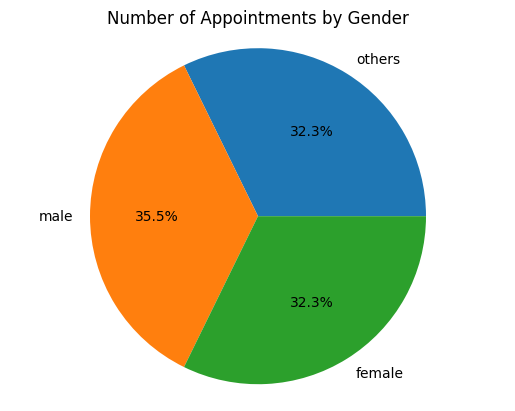

In [15]:
import json
import matplotlib.pyplot as plt


age_count = Counter(item['Age'] for item in extracted_data)
gender_count = Counter(item['gender'] for item in extracted_data)
valid_phone_numbers = sum(1 for item in extracted_data if item['isValidMobile'])
appointments_count = len(extracted_data)
medicines_count = sum(item['noOfMedicines'] for item in extracted_data)
active_medicines_count = sum(item['noOfActiveMedicines'] for item in extracted_data)


aggregated_data = {
    'Age': dict(age_count),
    'gender': dict(gender_count),
    'validPhoneNumbers': valid_phone_numbers,
    'appointments': appointments_count,
    'medicines': medicines_count,
    'activeMedicines': active_medicines_count
}


with open('aggregated_data.json', 'w') as json_file:
    json.dump(aggregated_data, json_file)


gender_labels = list(gender_count.keys())
gender_appointments = list(gender_count.values())

plt.pie(gender_appointments, labels=gender_labels, autopct='%1.1f%%')
plt.title('Number of Appointments by Gender')
plt.axis('equal')


plt.savefig('pie_chart.png')
